# A python notebook to show the noise optimizing model compared to simulation done by cadence

In [704]:
import numpy as np 
import matplotlib
# Forces the non-interactive backend designed for file output
matplotlib.use('Agg') 
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from scipy.optimize import curve_fit
import pandas as pd
import math
import os
colors = [
    '#000000',  # Black
    '#E69F00',  # Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Bluish Green
    '#F0E442',  # Yellow
    'purple',  # Blue
    '#D55E00',  # Vermilion
]

In [705]:
# --- Corrected rcParams Block ---
plt.rcParams.update({
    ## Text and Font Settings
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 25,
    "font.size": 16,
    "legend.fontsize": 16,
    "text.latex.preamble": r"\usepackage{amsmath}",

    ## Tick Settings
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.size": 8,
    "ytick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    
    ## Axes Line Width (for a bolder border)
    "axes.linewidth": 1.5,
    
    ## Turn the default grid OFF in rcParams
    "axes.grid": False,
})

### Simple function to target frequency or current at a certain frequency

In [706]:
#find the noise value at certain current 
def find_noise_at_current(target_I, real_I, noise_data):
    for I_target in target_I:
        print(f"Results for Current: {I_target} A")
        
        # Find the closest frequency in the data
        I_diffs = np.abs(real_I - I_target)
        idx = I_diffs.idxmin()
        I_actual = real_I.at[idx]
        print(f"Using actual current from data: {I_actual} A\n")
        # print(I_actual/600)
        noise_vals = []
        print(f"Noise at Ic = {np.round(I_actual,4)} A is Sv = {np.round((noise_data.at[idx])**2,20)} V^2/Hz\n")
#find the noise value at certain frequency
def find_noise_at_current(target_f, real_f, noise_data):
    for f_target in target_f:
        print(f"Results for Frequency: {f_target} Hz")
        
        # Find the closest frequency in the data
        f_diffs = np.abs(real_f - f_target)
        idx = f_diffs.idxmin()
        f_actual = real_f.at[idx]
        print(f"Using actual frequency from data: {f_actual} Hz\n")
        # print(I_actual/600)
        noise_vals = []
        print(f"Noise at Ic = {np.round(f_actual,4)} A is Sv = {np.round((noise_data.at[idx])**2,20)} V^2/Hz\n")

### Read data

In [707]:
dir = "../data" # Directory containing data files
compare_opt = pd.read_csv(f"{dir}/compare_to_optimize1.csv")
compare_opt.columns = ['Rptat2','IcRc','Ic','Noise_1Hz','Noise_1kHz']
Ic = compare_opt['Ic'].values
np.size(Ic)
# Load data
dir = "../data" # Directory containing data files
plot_dir = "../image/plot"
input_noise = pd.read_csv(f"{dir}/Noise_sim_postlayout.csv")
gain = pd.read_csv(f"{dir}/Gain_mag_phase.csv")
drift = pd.read_csv(f"{dir}/gain_drift.csv")
gain_test = pd.read_csv(f"{dir}/CMRR_test.csv")
compare_opt = pd.read_csv(f"{dir}/compare_to_optimize1.csv")
compare_opt_1stage = pd.read_csv(f"{dir}/compare_to_optimize_1st_stage.csv")
compare_opt_1stage_ideal = pd.read_csv(f"{dir}/compare_to_optimize_1st_stage_ideal.csv")

                        

### Input noise modelling

1. Input noise model of the first stage (CE) and second stage (CC) 

$$
\begin{align}
S_{v,CE} &=
        \underbrace{\frac{4kT}{R_C g_{m1}^2}}_{\substack{\text{Thermal noise} \\ \text{load } R_C}}
        + \underbrace{\frac{2qI_{C1}}{g_{m1}^2}}_{\substack{\text{Shot} \\ \text{noise}}}
        + \underbrace{4kTR_{BB'1}}_{\substack{\text{Thermal noise} \\ R_{BB'1}}}
        + \underbrace{\left(2qI_{b_1} + \frac{K_F I_{b_1}^2}{f} \right) R_{in}^2}_{\substack{\text{Input shot} \\ + \text{flicker noise}}} \\[1em]

\end{align}
$$


$$
\begin{align}
S_{v,CC} &=
        \underbrace{4kTR_{BB'4}}_{\substack{\text{Thermal noise} \\ R_{BB'4}}}
        + \underbrace{\frac{2qI_{C4}}{g_{m4}^2}}_{\substack{\text{Output shot} \\ \text{noise } Q_4}}
        + \underbrace{\frac{2qI_{C6}}{g_{m4}^2}}_{\substack{\text{Shot noise} \\ \text{load } Q_6}}
        + \underbrace{\left(2qI_{b3} + \frac{K_F I_{b_3}^2}{f} \right)R_C^2 }_{\substack{\text{Flicker noise} \\ Q_4}}
\end{align}
$$

Total input referred noise: 

$$
S_{v,tot} = \sqrt{S_{v,CE} + \frac{1}{A_{v,CE}}S_{v,CC}}
$$


In [708]:
import numpy as np

# --- Constants & Globals ---

constRI = 0.95
k = 1.380649e-23  # Boltzmann constant
q = 1.602176e-19  # Elementary charge

KF = 6.756e-11  # Flicker noise coefficient
afn = 1.53       # Flicker noise exponent
# T must be defined in your scope, e.g., T = 300

# ==========================================
# ------ First stage ----- Common-Emitter --
# ==========================================

def therm_Rc(Ic, T):
    Ic = np.asarray(Ic)
    return 2 * (k * T)**1.5 / (q * np.sqrt(constRI * Ic))

def shot_Ic(Ic, T):
    Ic = np.asarray(Ic)
    return np.sqrt(2) * k * T / (np.sqrt(q * Ic))

# ------- model included --------------------

def therm_Rbb(Ic, El, Nx):
    Ic = np.asarray(Ic)
    # Calculate the scalar noise value
    noise_val = np.sqrt(4 * k * T * 8 * (2.5 / El)**0.75 * (4 / Nx))
    # Create an array of this value matching the shape of Ic (works for scalars too)
    return np.full_like(Ic, noise_val, dtype=float)

def inshot(Ic, El, Nx, beta):
    Ic = np.asarray(Ic)
    h11 = beta / (Ic / (k * T / q))
    
    # Calculate factor A
    # Note: 50 is assumed to be a resistor value or constant
    R_term = 8 * (2.5 / El)**0.75 * (4 / Nx)
    numerator = 50 + R_term
    denominator = (numerator / h11) + 1
    A = numerator / denominator
    
    return np.sqrt((2 * q * Ic / beta)) * A 

def flicker(Ic, El, Nx, beta, f, KF, afn):
    Ic = np.asarray(Ic)
    f = np.asarray(f)  # Ensure f is handled as array for sweeping
    
    h11 = beta / (Ic / (k * T / q))
    
    R_term = 8 * (2.5 / El)**0.75 * (4 / Nx)
    numerator = 50 + R_term
    denominator = (numerator / h11) + 1
    A = numerator / denominator
    
    # Using np.asarray ensures this works if f is array and Ic scalar, or vice versa
    return np.sqrt(((KF) * (2.5 / El) * (4 / Nx) * Ic**afn) / (beta**afn * f**1)) * A 


# ==========================================
# ------ 2nd stage ----- Common-Collector --
# ==========================================

def gain_CE(constRI, T):
    # This returns a scalar, which numpy handles fine when multiplying with arrays later
    return constRI / (k * T / q)

def shot_Q46(Ic2, Ic, T):
    # Ic is passed just for shape reference if needed, but the formula relies on Ic2
    Ic2 = np.asarray(Ic2)
    # If Ic2 is fixed (scalar) and Ic is sweeping (array), we want the output to match Ic's shape
    # We add (Ic * 0) to force broadcasting to the shape of the sweeping variable
    Ic = np.asarray(Ic)
    val = np.sqrt((4 / Ic2) * k**2 * T**2 / q)
    return val + (Ic * 0) 

# ------- model included --------------------

def therm_Rbb2(Ic, El, Nx2):
    Ic = np.asarray(Ic)
    val = np.sqrt(4 * k * T * 8 * (2.5 / El)**0.75 * (4 / Nx2))
    return np.full_like(Ic, val, dtype=float)

def inshot2(Ic2, Ic, El, Nx2, beta):
    Ic2 = np.asarray(Ic2)
    Ic = np.asarray(Ic)
    
    A = constRI / Ic
    # Ensure broadcasting works between Ic (sweeping) and Ic2 (fixed)
    return np.sqrt((2 * q * Ic2 / beta)) * A 

def flicker2(Ic2, Ic, El, Nx2, beta, f, KF, afn):
    Ic2 = np.asarray(Ic2)
    Ic = np.asarray(Ic)
    f = np.asarray(f)
    
    A = constRI / Ic
    
    # Calculate noise using Ic2 (current) but modulated by A (which depends on Ic)
    # Divided by f (frequency)
    noise_part = np.sqrt(((KF) * (2.5 / El) * (4 / Nx2) * Ic2**afn) / (beta**afn * f**1))
    
    return noise_part * A
# Plot noise spectrum in frequency domain
def input_referred_noise(Ic, Ic2, El, Nx, Nx2, beta, f, KF, afn, constRI, T):
    # 1. Ensure inputs are arrays for broadcasting
    # This prevents errors if f or Ic are passed as simple floats
    Ic = np.asarray(Ic)
    f = np.asarray(f)
    
    # --- STAGE 1 NOISE (Common Emitter) ---
    # We square the ASD (Amplitude Spectral Density) to get PSD (Power Spectral Density)
    # The factor 2 (from np.sqrt(2)**2) represents differential topology (2 transistors)
    
    S1_sq = 2 * therm_Rc(Ic, T)**2
    S2_sq = 2 * shot_Ic(Ic, T)**2
    S3_sq = 2 * therm_Rbb(Ic, El, Nx)**2
    S4_sq = 2 * inshot(Ic, El, Nx, beta)**2
    
    # Flicker is frequency dependent
    S5_sq = 2 * flicker(Ic, El, Nx, beta, f, KF, afn)**2

    # Total Stage 1 PSD (V^2/Hz)
    # Numpy broadcasting automatically handles adding scalar S_thermal to vector S_flicker
    S_stage1_PSD = S1_sq + S2_sq + S3_sq + S4_sq + S5_sq

    # --- STAGE 2 NOISE (Common Collector) ---
    G = gain_CE(constRI, T) # Voltage Gain
    
    S1_2_sq = 2 * shot_Q46(Ic2, Ic, T)**2
    S2_2_sq = 2 * therm_Rbb2(Ic, El, Nx2)**2
    S3_2_sq = 2 * inshot2(Ic2, Ic, El, Nx2, beta)**2
    S4_2_sq = 2 * flicker2(Ic2, Ic, El, Nx2, beta, f, KF, afn)**2
    
    # Total Stage 2 PSD referred to input (divide by Gain^2)
    S_stage2_PSD_input_referred = (S1_2_sq + S2_2_sq + S3_2_sq + S4_2_sq) / (G**2)

    # --- TOTAL INPUT REFERRED NOISE ---
    # Sum PSDs and take square root to return ASD (V/rtHz)
    total_noise = np.sqrt(S_stage1_PSD + S_stage2_PSD_input_referred)
    
    return total_noise

### 

0.95


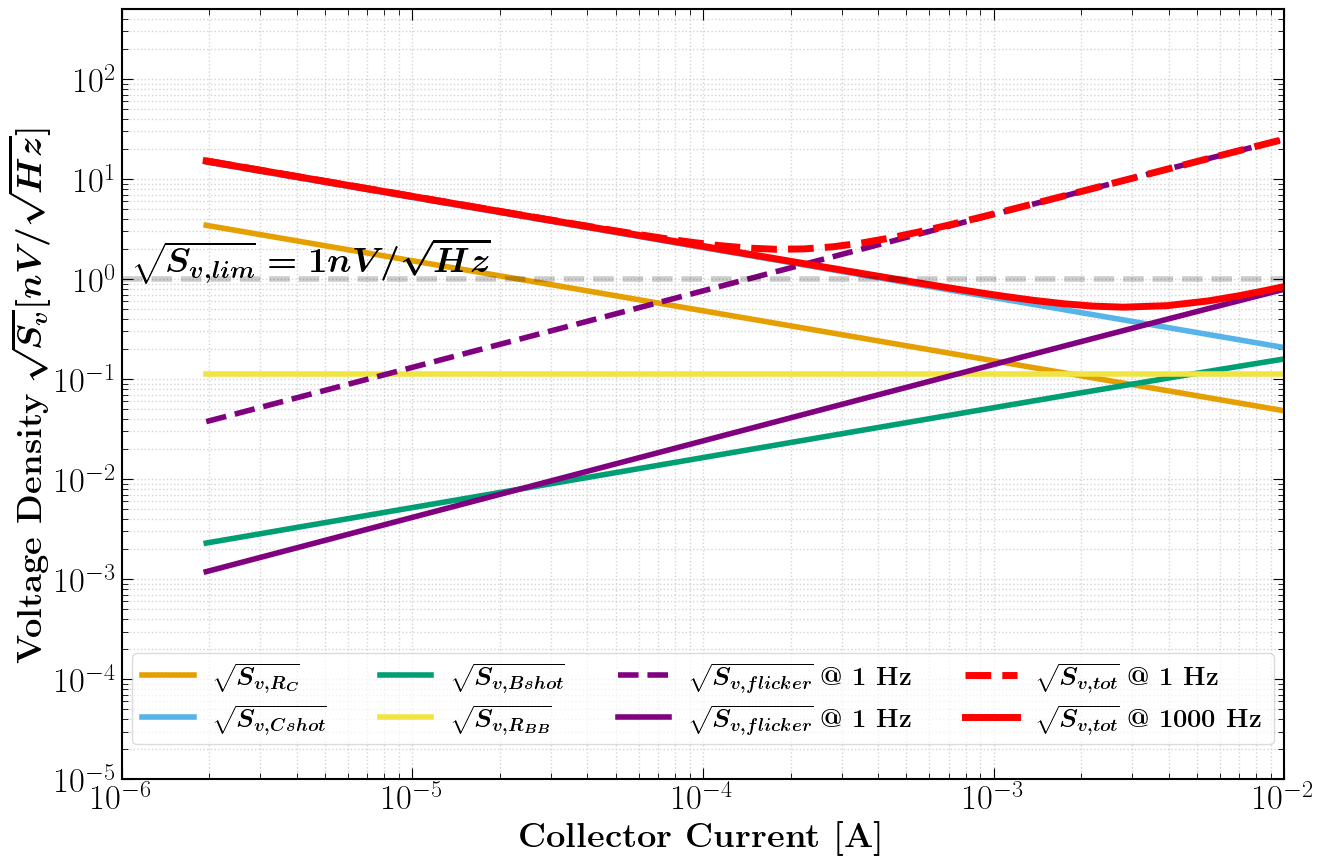

In [709]:

# Perform an optimization sweep with IC from data
# --- 1. Initial Setup and Data Calculation ---


El = 5
Nx = 50
f1 = 1
f2 = 1e3
f3 = 1e6
T = 300
beta = 600
T_test = [77,300]
# Data generation
k = 1.38e-23
q = 1.6e-19

print(constRI)
# Calculate all noise components
S1 = np.sqrt(2) * therm_Rc(Ic, T)
S2 = np.sqrt(2) * shot_Ic(Ic, T)
S3 = np.sqrt(2) * therm_Rbb(Ic, El, Nx)
S4 = np.sqrt(2) * inshot(Ic, El, Nx, beta)
S51 = np.sqrt(2) * flicker(Ic, El, Nx, beta, f1,KF,afn)
S52 = np.sqrt(2) * flicker(Ic, El, Nx, beta, f2,KF,afn)
# S53 = np.sqrt(2) * flicker(Ic, El, Nx, beta, f3)

# Define the components and their corresponding labels and styles
S_components = [S1, S2, S4, S3, S51, S52]#, S53]


flicker_styles = ['dashed', 'solid']


# --- Calculate two separate total noise curves ---
base_noise_sq = S1**2 + S2**2 + S3**2 + S4**2

# Total noise with 1 Hz flicker
total_noise_1Hz = np.sqrt(base_noise_sq + S51**2)

# Total noise with 1000 Hz flicker
total_noise_1kHz = np.sqrt(base_noise_sq + S52**2)


# --- Plotting ---
fig, ax = plt.subplots(figsize=(15, 10))

# Plot individual components (optional, but good for context)
ax.loglog(Ic, S1 * 1e9,  lw=4, color=colors[1], label=r'$\boldsymbol{\sqrt{S_{v,R_C}}}$')
ax.loglog(Ic, S2 * 1e9,  lw=4, color=colors[2], label=r'$\boldsymbol{\sqrt{S_{v,Cshot}}}$')
ax.loglog(Ic, S4 * 1e9,  lw=4, color=colors[3], label=r'$\boldsymbol{\sqrt{S_{v,Bshot}}}$')
ax.loglog(Ic, S3 * 1e9,  lw=4, color=colors[4], label=r'$\boldsymbol{\sqrt{S_{v,R_{BB}}}}$')

ax.loglog(Ic, S51 * 1e9, lw=4, color=colors[5], linestyle = 'dashed', label=r'$\boldsymbol{\sqrt{S_{v,flicker}}}$ \textbf{@ 1 Hz}')
ax.loglog(Ic, S52 * 1e9, lw=4, color=colors[5], label=r'$\boldsymbol{\sqrt{S_{v,flicker}}}$ \textbf{@ 1 Hz}')

# Plot the two distinct total noise curves
ax.loglog(Ic, total_noise_1Hz * 1e9,  color='red', lw=5, linestyle='dashed', label=r'$\boldsymbol{\sqrt{S_{v,tot}}}$ \textbf{@ 1 Hz}')
ax.loglog(Ic, total_noise_1kHz * 1e9, color='red', lw=5, linestyle='solid',  label=r'$\boldsymbol{\sqrt{S_{v,tot}}}$ \textbf{@ 1000 Hz}')

# --- Configure and decorate the plot ---
ax.axhline(y=1, linestyle='dashed', lw=4, alpha=0.2, color='black')
ax.text(1.1e-6, 1.2, r'$\boldsymbol{\sqrt{S_{v,lim}} = 1 nV / \sqrt{Hz}}$', fontsize=25)
# ax.set_title(r'Input noise of LNA @%d K ($E_l$ = %d $\mu m$, $N_x =$%d)' % (T, El, Nx), fontsize=25)
ax.set_xlabel(r'\textbf{Collector Current [A]}', fontsize=25)
ax.set_ylabel(r'\textbf{Voltage Density} $\boldsymbol{\sqrt{S_v} [nV/ \sqrt{Hz}]}$', fontsize=25)
plt.ylim(1e-5,5e2)
plt.xlim(1e-8,1e-2)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.18),
          fancybox=True, shadow=False, ncol=4, fontsize=18.5,
          framealpha=0.7) # Set opacity to 70%
plt.xlim(1e-6, 1e-2)

#add data into df 
data = {'Ic': Ic ,
        'Noise_1Hz': total_noise_1Hz,
        'Noise_1kHz': total_noise_1kHz}
# print(data)
df = pd.DataFrame(data)


# Define your path
output_path = f'../data/optimize_calculate_at_Nx{Nx}1st.csv'

# 1. Get the directory name from the path (ignores the filename)
output_dir = os.path.dirname(output_path)

# 2. Create the directory if it doesn't exist
# exist_ok=True prevents errors if the folder already exists
os.makedirs(output_dir, exist_ok=True)

# 3. NOW you can save the file
df.to_csv(output_path, index=False, encoding='utf-8-sig')

   


Gain CE = 36.71497584541062


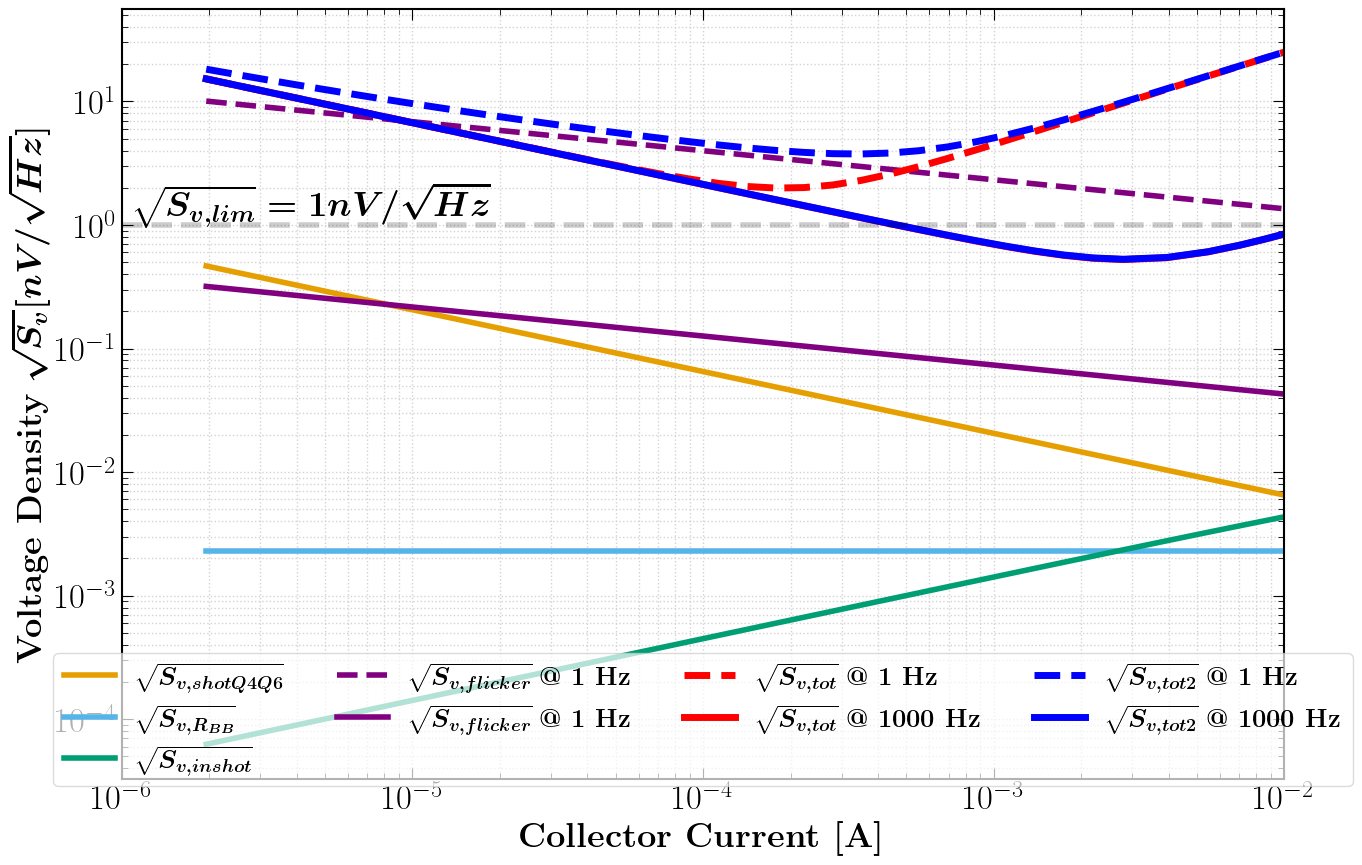

In [710]:

Ic2 = 1.5*Ic
Nx2 = 90
G = gain_CE(constRI,T)
print(f'Gain CE = {G}')
S1 = np.sqrt(2) * shot_Q46(Ic2,Ic,T)
S2 = np.sqrt(2) * therm_Rbb2(Ic,El,Nx2)
S3 = np.sqrt(2) * inshot2(Ic2,Ic,El,Nx2,beta)
S41 = np.sqrt(2) * flicker2(Ic2,Ic,El,Nx2,beta, f1,KF,afn)
S42 = np.sqrt(2) * flicker2(Ic2,Ic,El,Nx2,beta, f2,KF,afn)


flicker_styles = ['dashed', 'solid']


# --- Calculate two separate total noise curves ---
base_noise_sq2 = (S1**2 + S2**2 + S3**2 ) 
# base_noise_sq2 = 0
# Total noise with 1 Hz flicker
# total_noise_1Hz2 = np.sqrt(base_noise_sq2 + S41**2)/G
total_noise_1Hz2 = np.sqrt((S41/G)**2 + (base_noise_sq2/G)**2  + total_noise_1Hz**2)
# Total noise with 1000 Hz flicker
# total_noise_1kHz2 = np.sqrt(base_noise_sq2 + S42**2)/G
total_noise_1kHz2 = np.sqrt((S42/G)**2 + (base_noise_sq2/G)**2 + total_noise_1kHz**2)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(15, 10))

# # # # Plot individual components (optional, but good for context)
ax.loglog(Ic, S1/G * 1e9,  lw=4, color=colors[1], label=r'$\boldsymbol{\sqrt{S_{v,shotQ4Q6}}}$')
ax.loglog(Ic, S2/G * 1e9,  lw=4, color=colors[2], label=r'$\boldsymbol{\sqrt{S_{v,R_{BB}}}}$')
ax.loglog(Ic, S4/G * 1e9,  lw=4, color=colors[3], label=r'$\boldsymbol{\sqrt{S_{v,inshot}}}$')

ax.loglog(Ic, S41/G * 1e9, lw=4, color=colors[5], linestyle = 'dashed', label=r'$\boldsymbol{\sqrt{S_{v,flicker}}}$ \textbf{@ 1 Hz}')
ax.loglog(Ic, S42/G * 1e9, lw=4, color=colors[5], label=r'$\boldsymbol{\sqrt{S_{v,flicker}}}$ \textbf{@ 1 Hz}')

# # Plot the two distinct total noise curves
ax.loglog(Ic, total_noise_1Hz * 1e9,  color='red', lw=5, linestyle='dashed', label=r'$\boldsymbol{\sqrt{S_{v,tot}}}$ \textbf{@ 1 Hz}')
ax.loglog(Ic, total_noise_1kHz * 1e9, color='red', lw=5, linestyle='solid',  label=r'$\boldsymbol{\sqrt{S_{v,tot}}}$ \textbf{@ 1000 Hz}')

ax.loglog(Ic, total_noise_1Hz2 * 1e9,  color='blue', lw=5, linestyle='dashed', label=r'$\boldsymbol{\sqrt{S_{v,tot2}}}$ \textbf{@ 1 Hz}')
ax.loglog(Ic, total_noise_1kHz2 * 1e9, color='blue', lw=5, linestyle='solid',  label=r'$\boldsymbol{\sqrt{S_{v,tot2}}}$ \textbf{@ 1000 Hz}')

# --- Configure and decorate the plot ---

# --- Configure and decorate the plot ---
ax.axhline(y=1, linestyle='dashed', lw=4, alpha=0.2, color='black')
ax.text(1.1e-6, 1.2, r'$\boldsymbol{\sqrt{S_{v,lim}} = 1 nV / \sqrt{Hz}}$', fontsize=25)
# ax.set_title(r'Input noise of LNA @%d K ($E_l$ = %d $\mu m$, $N_x =$%d)' % (T, El, Nx), fontsize=25)
ax.set_xlabel(r'\textbf{Collector Current [A]}', fontsize=25)
ax.set_ylabel(r'\textbf{Voltage Density} $\boldsymbol{\sqrt{S_v} [nV/ \sqrt{Hz}]}$', fontsize=25)
# plt.ylim(1e-5,5e2)
plt.xlim(1e-6, 1e-2)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.18),
          fancybox=True, shadow=False, ncol=4, fontsize=18.5,
          framealpha=0.7) # Set opacity to 70%

#add data into df 
data = {'Ic': Ic ,
        'Noise_1Hz': total_noise_1Hz2,
        'Noise_1kHz': total_noise_1kHz2}

df = pd.DataFrame(data)

# Define your path
output_path = f'../data/optimize_calculate_at_Nx{Nx}_tot.csv'

# 1. Get the directory name from the path (ignores the filename)
output_dir = os.path.dirname(output_path)

# 2. Create the directory if it doesn't exist
# exist_ok=True prevents errors if the folder already exists
os.makedirs(output_dir, exist_ok=True)

# 3. NOW you can save the file
df.to_csv(output_path, index=False, encoding='utf-8-sig')


# Plot a spectrum in frequency domain at certain current 

In [711]:
# call frequency domain data
input_noise = pd.read_csv(f"{dir}/Noise_sim_postlayout.csv")
input_noise.columns = ['f','LNA1','LNA2']
f_real = input_noise['f'].values
measured_noise = input_noise['LNA2'].values

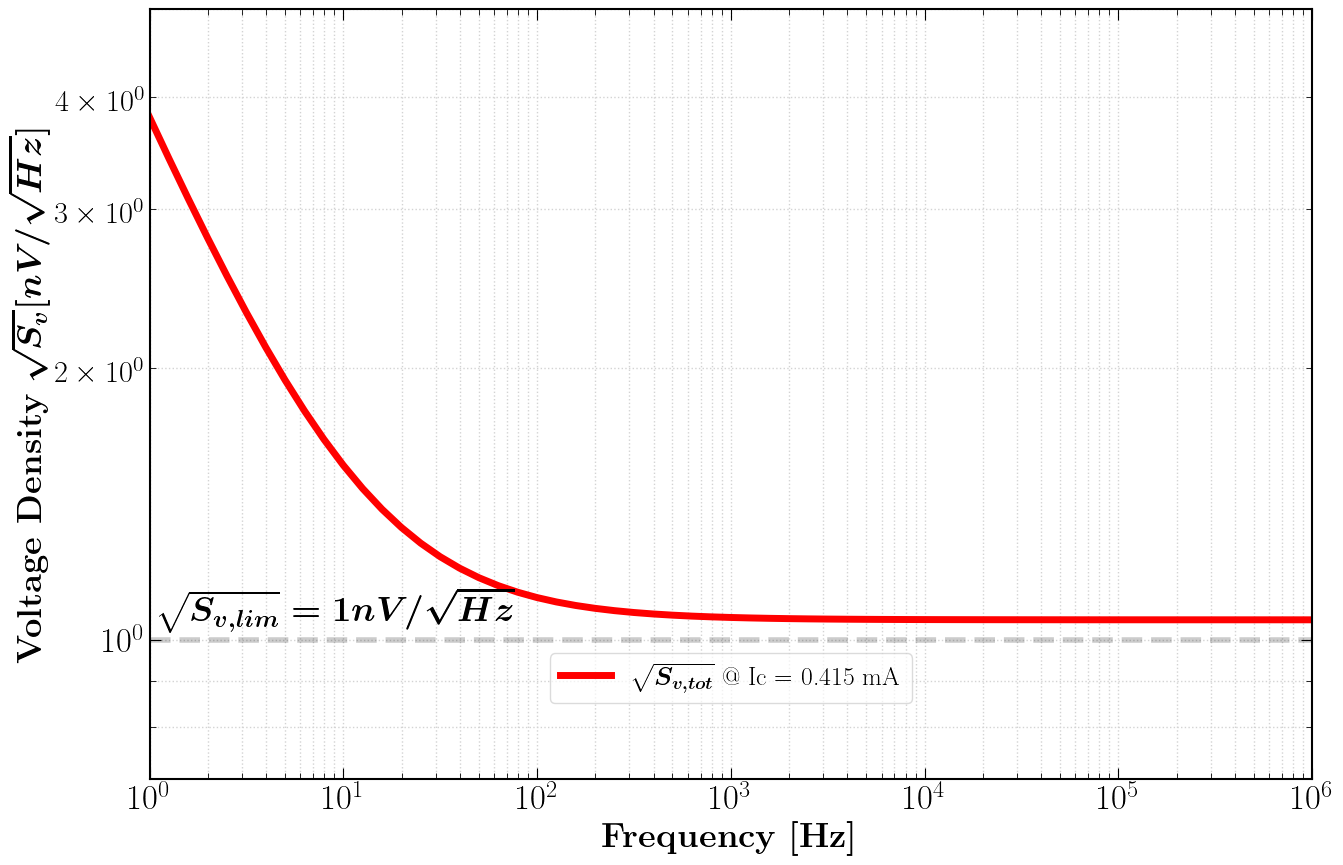

              Ic   Input_noise
0   1.000000e+00  3.795730e-09
1   1.258930e+00  3.416400e-09
2   1.584890e+00  3.082007e-09
3   1.995260e+00  2.787943e-09
4   2.511890e+00  2.530117e-09
..           ...           ...
86  3.981070e+08  1.051705e-09
87  5.011870e+08  1.051705e-09
88  6.309570e+08  1.051705e-09
89  7.943280e+08  1.051705e-09
90  1.000000e+09  1.051705e-09

[91 rows x 2 columns]


In [712]:
f = f_real
Ic = 415e-6 
Ic2 = 1.5 * Ic

total_noise_spectrum = input_referred_noise(Ic, Ic2, El, Nx, Nx2, beta, f, KF, afn, constRI, T)
fig, ax = plt.subplots(figsize=(15, 10))
ax.loglog(f, total_noise_spectrum * 1e9, lw=5, color='red', label=r'$\boldsymbol{\sqrt{S_{v,tot}}}$ @ Ic = %.3f mA' % (Ic*1e3))
ax.axhline(y=1, linestyle='dashed', lw=4, alpha=0.2, color='black')
ax.text(1.1e0, 1.05, r'$\boldsymbol{\sqrt{S_{v,lim}} = 1 nV / \sqrt{Hz}}$', fontsize=25)
ax.set_xlabel(r'\textbf{Frequency [Hz]}', fontsize=25)
ax.set_ylabel(r'\textbf{Voltage Density} $\boldsymbol{\sqrt{S_v} [nV/ \sqrt{Hz}]}$', fontsize=25)
plt.ylim(1e-2,5e2)
plt.xlim(1e0,1e6)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.18),
          fancybox=True, shadow=False, ncol=2, fontsize=18.5,
          framealpha=0.7) # Set opacity to 70%
ax.set_ylim(7e-1,0.5e1)
plt.show()      

#add data into df 
data = {'Ic': f ,
        'Input_noise': total_noise_spectrum}

df = pd.DataFrame(data)

import os

# Define your path
output_path = f'../data/inputnoise_calculate_tot.csv'

# 1. Get the directory name from the path (ignores the filename)
output_dir = os.path.dirname(output_path)

# 2. Create the directory if it doesn't exist
# exist_ok=True prevents errors if the folder already exists
os.makedirs(output_dir, exist_ok=True)

# 3. NOW you can save the file
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(df)

Define equation to fit the spectrum for **KF** and $\afn$

In [713]:

def fit_psd_log(f_data, measured_noise_data, Ic, Ic2, El, Nx, Nx2, beta, p0_guess=None):
    """
    Fits the input_referred_noise model to measured data using a log-log approach.

    Args:
        f_data (np.ndarray): Array of frequency values (Hz).
        measured_noise_data (np.ndarray): Array of measured Input-Referred Noise (V/sqrt(Hz)).
        Ic (float): Fixed first-stage collector current (A).
        Ic2 (float): Fixed second-stage collector current (A).
        El (float): Fixed Length parameter.
        Nx (float): Fixed Number of fingers in Q1.
        Nx2 (float): Fixed Number of fingers in Q2.
        beta (float): Fixed beta parameter.
        p0_guess (list, optional): Initial guess for [KF, afn]. 
                                     Defaults to a common starting point.

    Returns:
        tuple: (popt, pcov), the optimal parameters [KF, afn] and covariance matrix.
    """
    
    # 1. Prepare fixed parameters and model arguments
    fixed_params = (Ic, Ic2, El, Nx, Nx2, beta, constRI, T)
    
    if p0_guess is None:
        # Initial guess for KF (Flicker Noise Factor) and afn (Exponent)
        p0_guess = [1e-10, 1.0] 

    # 2. Define the Log-Log Model Function
    def log_model(f, KF, afn):
        """
        Model function for curve_fit: takes frequency and variable parameters,
        but returns the LOG of the noise.
        """
        # Calculate the noise using the full model
        noise_asd = input_referred_noise(
            Ic, Ic2, El, Nx, Nx2, beta, f, KF, afn, constRI, T
        )
        
        # Return the logarithm of the noise
        return np.log(noise_asd)

    # 3. Prepare the Data
    # The actual data we fit is the LOG of the measured noise
    log_data = np.log(measured_noise_data)
    
    # 4. Perform the Fit
    # By fitting log(Model) to log(Data) and providing no sigma, 
    # curve_fit performs an unweighted least squares fit on the log-transformed data.
    # This is equivalent to minimizing the relative error on the original data, 
    # which is the desired behavior for PSD/ASD data spanning decades.
    
    try:
        popt, pcov = curve_fit(
            f=log_model, 
            xdata=f_data, 
            ydata=log_data, 
            p0=p0_guess,
            # Set bounds to ensure physically meaningful results
            bounds=([1e-20, 0.0], [1.0, 3.0]), # KF must be > 0, afn usually between 0 and 3
            # You can also add `method='trf'` for more robust bounded fitting
        )
        
        # Unpack the fitted parameters
        KF_fit, afn_fit = popt
        
        print(f"✅ Fit Successful!")
        print(f"Optimal KF (Flicker Noise Factor): {KF_fit:.3e}")
        print(f"Optimal afn (Current Exponent): {afn_fit:.3f}")
        
        return popt, pcov

    except RuntimeError as e:
        print(f"❌ Fit Failed: {e}")
        print("Tip: Try adjusting the initial guess (p0_guess) or bounds.")
        return None, None


# --- Example Usage ---

# 1. Define typical fixed parameters and dummy data (for demonstration)
Ic_val = 415e-6  # 1 mA
Ic2_val = 1.5 * Ic_val # 0.5 mA
El_val = 5
Nx_val = 50
Nx2_val = 90
beta_val = 600.0

# Create dummy frequency data (spanning decades, 1 Hz to 1 GHz)
f_data_example = f_real # 100 points from 1 Hz to 1 GHz

# Create a baseline noise data set using known parameters (The 'True' values)
KF_true = KF
afn_true = afn

true_noise = input_referred_noise(
    Ic_val, Ic2_val, El_val, Nx_val, Nx2_val, beta_val, 
    f_data_example, KF_true, afn_true, constRI, T
)




# 2. Call the fitting function
print("--- Starting Fit ---")
optimal_params, covariance = fit_psd_log(
    f_data_example, 
    measured_noise, 
    Ic=Ic_val, Ic2=Ic2_val, El=El_val, Nx=Nx_val, Nx2=Nx2_val, beta=beta_val,
    p0_guess=[1e-12, 0.9] # A guess far from the true values to test the solver
)

# 3. Post-processing (Optional)
if optimal_params is not None:
    KF_opt, afn_opt = optimal_params
    
    # Calculate the model using the fitted parameters
    fitted_noise = input_referred_noise(
        Ic_val, Ic2_val, El_val, Nx_val, Nx2_val, beta_val, 
        f_data_example, KF_opt, afn_opt, constRI, T
    )
    
    # Calculate the standard error of the fit parameters
    perr = np.sqrt(np.diag(covariance))
    print("\nStandard Errors of the fit parameters:")
    print(f"KF Error: {perr[0]:.3e}")
    print(f"afn Error: {perr[1]:.3f}")

# --- End of Example ---

--- Starting Fit ---
✅ Fit Successful!
Optimal KF (Flicker Noise Factor): 6.756e-11
Optimal afn (Current Exponent): 1.535

Standard Errors of the fit parameters:
KF Error: 6.801e-10
afn Error: 0.027


<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/3716369373.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Input-Referred Noise ($\mathrm{V}/\sqrt{\mathrm{Hz}}$)', fontsize=12)


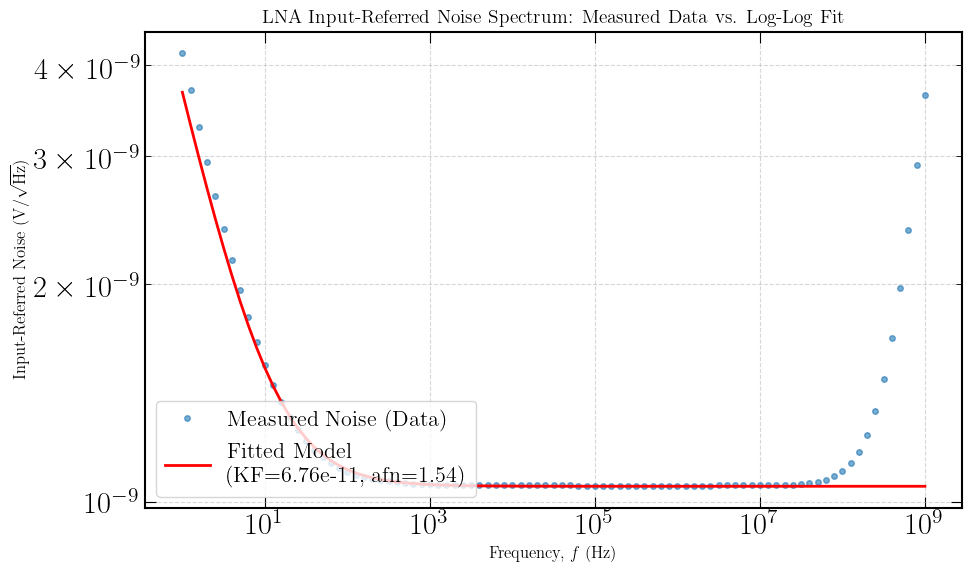

In [714]:
def plot_noise_spectrum_fit(
    f_data, 
    measured_noise, 
    fitted_noise, 
    KF_opt, 
    afn_opt
):
    """
    Plots the measured and fitted Input-Referred Noise (ASD) on a log-log scale.

    Args:
        f_data (np.ndarray): Array of frequency values (Hz).
        measured_noise (np.ndarray): Array of measured ASD (V/sqrt(Hz)).
        fitted_noise (np.ndarray): Array of fitted ASD from the model (V/sqrt(Hz)).
        KF_opt (float): Optimal fitted KF value.
        afn_opt (float): Optimal fitted afn value.
    """
    
    # Create the plot figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 1. Plot Measured Data
    # Use 'o' marker to show individual data points
    ax.loglog(
        f_data, 
        measured_noise, 
        'o', 
        markersize=4, 
        alpha=0.6, 
        label='Measured Noise (Data)'
    )
    
    # 2. Plot Fitted Model
    # Use a solid line for the continuous model fit
    # Create the label with the fitted parameters for easy reference
    fit_label = (
        f'Fitted Model\n'
        f'(KF={KF_opt:.2e}, afn={afn_opt:.2f})'
    )
    ax.loglog(
        f_data, 
        fitted_noise, 
        'r-', 
        linewidth=2, 
        label=fit_label
    )
    
    # 3. Enhance Plot Appearance
    ax.set_title(
        'LNA Input-Referred Noise Spectrum: Measured Data vs. Log-Log Fit',
        fontsize=14
    )
    ax.set_xlabel('Frequency, $f$ (Hz)', fontsize=12)
    # The unit for your noise function is V/sqrt(Hz), which is Amplitude Spectral Density (ASD)
    ax.set_ylabel('Input-Referred Noise ($\mathrm{V}/\sqrt{\mathrm{Hz}}$)', fontsize=12)
    
    # Optional: Add grid lines for better readability on log scale
    ax.grid(which='both', linestyle='--', alpha=0.5)
    
    # Add the legend to display which line is which
    ax.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

# --- Example of How to Use the Plotting Function ---

# Assuming the variables from the previous response's example were retained:
# KF_opt and afn_opt are the results from curve_fit.

if optimal_params is not None:
    KF_opt, afn_opt = optimal_params
    
    # Recalculate fitted_noise (already done in the previous step but shown again for clarity)
    fitted_noise = input_referred_noise(
        Ic_val, Ic2_val, El_val, Nx_val, Nx2_val, beta_val, 
        f_data_example, KF_opt, afn_opt, constRI, T
    )
    
    # Call the plotting function
    plot_noise_spectrum_fit(
        f_data_example, 
        measured_noise, 
        fitted_noise, 
        KF_opt, 
        afn_opt
    )

In [715]:

col = ['f', 'LNA1', 'LNA2']
input_noise.columns = col
op_noiserti_result = pd.read_csv(f"{dir}/inputnoise_calculate_tot.csv")
op_noiserti_result.columns = ['f','noise']
# --- 2. Plot Setup ---
plt.figure(figsize=(10, 10))


l1 = ax_left.loglog(input_noise['f'], input_noise['LNA1']*1e9, 
                    label='LNA1', color=colors[1], lw=3)
l2 = ax_left.loglog(input_noise['f'], input_noise['LNA2']*1e9, 
                    label='LNA2', color=colors[2], lw=3)
l3 = ax_left.loglog(op_noiserti_result['f'], op_noiserti_result['noise']*1e9,
               label=fr'Calculated Noise (KF = {np.round(KF_opt,15)}, $\afn$ = {np.round(afn_opt,3)} )', color=colors[3], lw=3, linestyle='--')
# --- 4. Formatting ---

# Global Settings
# plt.title(r'\textbf{Input Referred Noise vs Frequency}', fontsize=25, pad=20)
ax_left.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
ax_left.set_xlabel(r'\textbf{Frequency (Hz)}', fontsize=25)

# Left Y-Axis Formatting
ax_left.set_ylabel(r'\textbf{Voltage Density} $\boldsymbol{\sqrt{S_v} [nV/ \sqrt{Hz}]}$', 
                   fontsize=25)
ax_left.tick_params(axis='both', which='major', labelsize=25)


lines = l1 + l2 + l3 # Combine the lists of lines
labels = [l.get_label() for l in lines] # Extract labels

# Create one legend on the main axis
ax_left.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1),
               fancybox=True, shadow=False, ncol=3, fontsize=18.5,
               framealpha=0.7)

minor_locator = LogLocator(base=10.0, subs=(0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)

# 2. Apply it to the X-Axis
ax_left.xaxis.set_minor_locator(minor_locator)

# 3. Draw the Grids
ax_left.grid(True, which='major', linestyle='-', linewidth=0.8, color='lightgray')
ax_left.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, color='lightgray', alpha=0.7)
# Adjust x and y limits if necessary
ax_left.set_xlim(1, 20e6)
ax_left.set_ylim(7e-1,0.5e1)
# ax_left.set_ylim()
plt.tight_layout()
# plt.savefig(f"{plot_dir}/Input_Referred_Noise.png", dpi=300)
plt.show()


<Figure size 1000x1000 with 0 Axes>

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/3723907765.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/3723907765.py:39: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/3723907765.py:63: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)


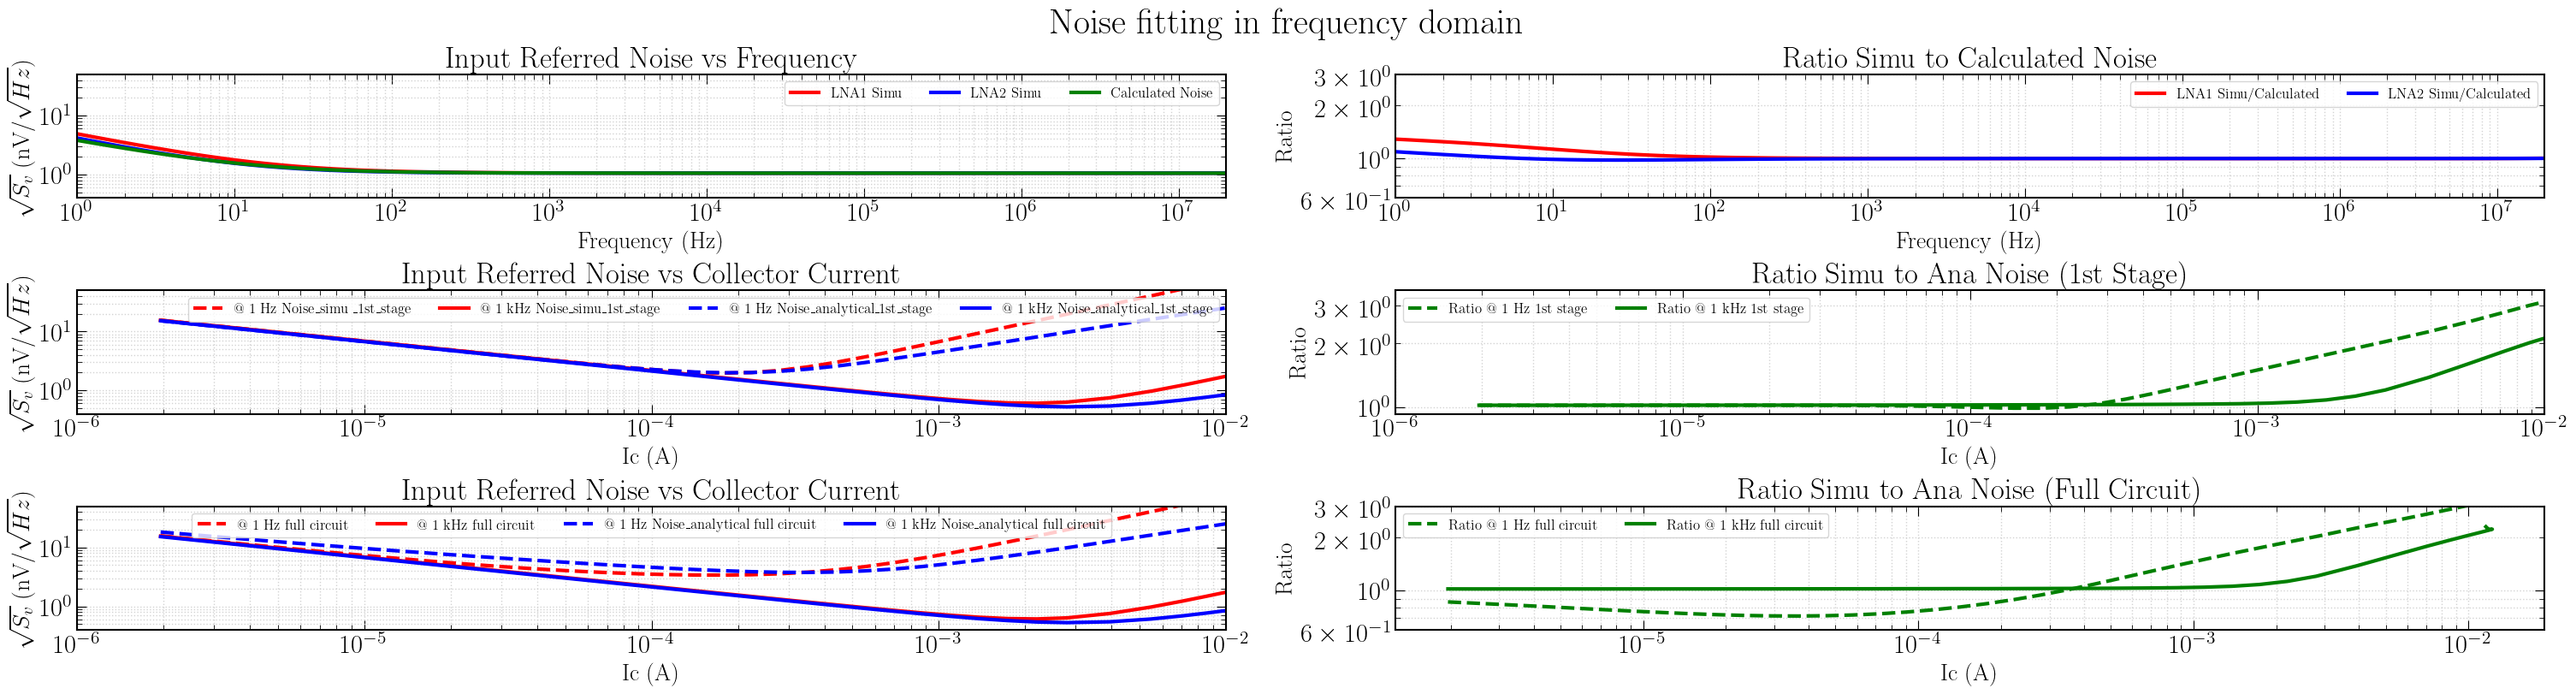

In [716]:
opt_cal1st = pd.read_csv(f"{dir}/optimize_calculate_at_Nx501st.csv")
opt_caltot = pd.read_csv(f"{dir}/optimize_calculate_at_Nx50_tot.csv")
# compare_opt.head()
compare_opt.columns = ['Rptat2','IcRc','Ic','Noise_1Hz','Noise_1kHz']
compare_opt_1stage.columns = ['Rptat2','Ic','Noise_1Hz','Noise_1kHz']
compare_opt_1stage_ideal.columns = ['Ic','Noise_1Hz','Noise_1kHz']
#Calculated 
opt_cal = pd.read_csv(f"{dir}/optimize_calculate_at_Nx50.csv")
plt.figure(figsize=(30,8), constrained_layout=True)
plt.suptitle('Noise fitting in frequency domain', fontsize=30)
plt.subplot(321)
plt.loglog(input_noise['f'], input_noise['LNA1']*1e9, color='red', lw = 3, label = 'LNA1 Simu')
plt.loglog(input_noise['f'], input_noise['LNA2']*1e9, color='blue', lw = 3, label = 'LNA2 Simu')
plt.loglog(op_noiserti_result['f'], op_noiserti_result['noise']*1e9, color='green', lw = 3, label = 'Calculated Noise')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)
plt.title('Input Referred Noise vs Frequency', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 3)
plt.xlim(1, 20e6)
plt.ylim(4e-1,5e1)  
plt.subplot(322)
plt.loglog(input_noise['f'], input_noise['LNA1']/op_noiserti_result['noise'], color='red', lw = 3, label = 'LNA1 Simu/Calculated')
plt.loglog(input_noise['f'], input_noise['LNA2']/op_noiserti_result['noise'], color='blue', lw = 3, label = 'LNA2 Simu/Calculated')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Ratio', fontsize=20)            
plt.title('Ratio Simu to Calculated Noise', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 2)
plt.xlim(1, 20e6)
plt.ylim(0.6,3)

plt.subplot(323)  
plt.loglog(compare_opt_1stage['Ic'], compare_opt_1stage['Noise_1Hz']*1e9,  color='red', linestyle='--', lw = 3, label = '@ 1 Hz Noise_simu _1st_stage')
plt.loglog(compare_opt_1stage['Ic'], compare_opt_1stage['Noise_1kHz']*1e9, color='red', linestyle='-', lw = 3, label = '@ 1 kHz Noise_simu_1st_stage')
plt.loglog(opt_cal1st['Ic'], opt_cal1st['Noise_1Hz']*1e9,  color='blue', linestyle='--', lw = 3, label = '@ 1 Hz Noise_analytical_1st_stage')
plt.loglog(opt_cal1st['Ic'], opt_cal1st['Noise_1kHz']*1e9, color='blue', linestyle='-', lw = 3, label = '@ 1 kHz Noise_analytical_1st_stage')
plt.xlabel('Ic (A)', fontsize=20)
plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)
plt.title('Input Referred Noise vs Collector Current', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 4)
plt.xlim(1e-6, 1e-2)
plt.ylim(4e-1,5e1)
# Plot ratio of analytical to simulated noise for 1st stage
plt.subplot(324)
plt.loglog(compare_opt_1stage['Ic'], compare_opt_1stage['Noise_1Hz']/opt_cal1st['Noise_1Hz'], color='green', linestyle='--', lw = 3, label = 'Ratio @ 1 Hz 1st stage')
plt.loglog(compare_opt_1stage['Ic'], compare_opt_1stage['Noise_1kHz']/opt_cal1st['Noise_1kHz'], color='green', linestyle='-', lw = 3, label = 'Ratio @ 1 kHz 1st stage')
plt.xlabel('Ic (A)', fontsize=20)
plt.ylabel('Ratio', fontsize=20)
plt.title('Ratio Simu to Ana Noise (1st Stage)', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 2)
plt.xlim(1e-6, 1e-2)
#
# plt.tight_layout()
plt.subplot(325)
plt.loglog(compare_opt['Ic'], compare_opt['Noise_1Hz']*1e9, color= 'red', linestyle='--', lw = 3, label = '@ 1 Hz  full circuit')
plt.loglog(compare_opt['Ic'], compare_opt['Noise_1kHz']*1e9, color='red', linestyle='-', lw = 3, label = '@ 1 kHz full circuit') 
plt.loglog(opt_caltot['Ic'], opt_caltot['Noise_1Hz']*1e9,  color='blue', linestyle='--', lw = 3, label = '@ 1 Hz Noise_analytical full circuit')
plt.loglog(opt_caltot['Ic'], opt_caltot['Noise_1kHz']*1e9, color='blue', linestyle='-', lw = 3, label = '@ 1 kHz Noise_analytical full circuit')
plt.xlabel('Ic (A)', fontsize=20)
plt.ylabel('$\sqrt{S_v}$ (nV/$\sqrt{Hz}$)', fontsize=20)
plt.title('Input Referred Noise vs Collector Current', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 4)
plt.ylim(4e-1,5e1)
plt.xlim(1e-6, 1e-2)
# plt.tight_layout()

#plot ratio of analytical to simulated noise for full circuit
plt.subplot(326)
plt.loglog(compare_opt['Ic'], compare_opt['Noise_1Hz']/opt_caltot['Noise_1Hz'], color='green', linestyle='--', lw = 3, label = 'Ratio @ 1 Hz full circuit')
plt.loglog(compare_opt['Ic'], compare_opt['Noise_1kHz']/opt_caltot['Noise_1kHz'], color='green', linestyle='-', lw = 3, label = 'Ratio @ 1 kHz full circuit')
plt.xlabel('Ic (A)', fontsize=20)
plt.ylabel('Ratio', fontsize=20)
plt.title('Ratio Simu to Ana Noise (Full Circuit)', fontsize=25)
plt.grid(True, which='both', linestyle=':', linewidth=1, color='lightgray')
plt.legend(fontsize=12, ncols = 2) 
plt.ylim(0.6,3)
plt.show()


In [729]:
# Define the global fixed frequency for this measurement sweep
# This is the single frequency at which the noise data was measured.
FIXED_FREQUENCY = 1  # Example: Noise measured at 100 Hz (or whatever your measurement frequency is)

def fit_noise_vs_ic_log(
    Ic_data,                      # <-- NEW: The X-axis is now Ic array
    measured_noise_data,
    f_fixed,                      # <-- NEW: A single fixed frequency (scalar)
    Ic2, El, Nx, Nx2, beta, 
    p0_guess=None
):
    """
    Fits the input_referred_noise model to measured data using a log-log approach,
    where the X-axis is the collector current (Ic).

    Args:
        Ic_data (np.ndarray): Array of first-stage collector current values (A).
        measured_noise_data (np.ndarray): Array of measured Input-Referred Noise (V/sqrt(Hz)).
        f_fixed (float): The single fixed frequency (Hz) at which the measurement was taken.
        Ic2 (float): Fixed second-stage collector current (A).
        El (float): Fixed Length parameter.
        Nx (float): Fixed Number of fingers in Q1.
        Nx2 (float): Fixed Number of fingers in Q2.
        beta (float): Fixed beta parameter.
        p0_guess (list, optional): Initial guess for [KF, afn]. 
                                     Defaults to a common starting point.

    Returns:
        tuple: (popt, pcov), the optimal parameters [KF, afn] and covariance matrix.
    """
    
    # Global constants must be accessible (k, T, constRI, q)
    global k, q, T, constRI 
    
    if p0_guess is None:
        # Initial guess for KF (Flicker Noise Factor) and afn (Current Exponent)
        p0_guess = [1e-10, 1.0] 

    # 1. Define the Log-Log Model Function for Ic sweep
    def log_model_ic_sweep(Ic_array, KF, afn):
        """
        Model function for curve_fit: Ic_array is the X-data (fitting variable).
        Returns the LOG of the noise at the FIXED frequency (f_fixed).
        """
        # Calculate the noise using the full model, passing Ic_array as the sweeping variable
        noise_asd = input_referred_noise(
            Ic=Ic_array,            # <-- The sweeping variable
            Ic2=Ic2, 
            El=El, 
            Nx=Nx, 
            Nx2=Nx2, 
            beta=beta, 
            f=f_fixed,              # <-- The fixed frequency
            KF=KF, 
            afn=afn,              # Note: Changed 'afn' to 'afn' in model call
            constRI=constRI, 
            T=T
        )
        
        # Return the logarithm of the noise (V/sqrt(Hz))
        return np.log(noise_asd)

    # 2. Prepare the Data
    # The actual data we fit is the LOG of the measured noise
    log_data = np.log(measured_noise_data)
    
    # 3. Perform the Fit
    try:
        popt, pcov = curve_fit(
            f=log_model_ic_sweep, 
            xdata=Ic_data,             # <-- X-data is the Ic array
            ydata=log_data, 
            p0=p0_guess,
            # Set bounds: KF must be > 0, afn usually between 0 and 3
            bounds=([1e-20, 0.0], [1.0, 3.0]) 
        )
        
        # Unpack the fitted parameters
        KF_fit, afn_fit = popt
        
        print(f"✅ Fit Successful (Noise vs. Ic Sweep)!")
        print(f"Fixed Frequency: {f_fixed} Hz")
        print(f"Optimal KF (Flicker Noise Factor): {KF_fit:.3e}")
        print(f"Optimal afn (Current Exponent): {afn_fit:.3f}")
        
        return popt, pcov

    except RuntimeError as e:
        print(f"❌ Fit Failed: {e}")
        print("Tip: Check Ic_data and measured_noise_data for size matching and try adjusting p0_guess.")
        return None, None

# --- Example Usage for Ic Sweep ---

# 1. Define fixed parameters (for demonstration)
# You should replace these with your actual physical and bias parameters.
Ic2_val = 1.5e-3
El_val = 5.0
Nx_val = 50.0
Nx2_val = 90.0
beta_val = 600.0
f_meas = 1  # Noise is measured at 100 Hz

# Create dummy Ic data (spanning decades, e.g., 1 uA to 10 mA)
Ic_data_example = compare_opt['Ic'].values

# Create baseline noise data using known 'True' values (assuming they are defined globally)
# For this example to run, you need the original functions and global constants defined.
# I'll use placeholders for KF and afn for the "true" model
KF_true_val = 3.5e-11
afn_true_val = 1.05

try:
    measured_noise_ic = compare_opt['Noise_1Hz'].values  # Replace with actual measured data

    # 2. Call the fitting function
    print("\n--- Starting Noise vs. Current Fit ---")
    optimal_params_ic, covariance_ic = fit_noise_vs_ic_log(
        Ic_data_example, 
        measured_noise_ic, 
        f_fixed=f_meas,
        Ic2=Ic2_val, El=El_val, Nx=Nx_val, Nx2=Nx2_val, beta=beta_val,
        p0_guess=[1e-12, 0.9] 
    )

    # 3. Post-processing
    if optimal_params_ic is not None:
        KF_opt_ic, afn_opt_ic = optimal_params_ic
        
        # Calculate the model using the fitted parameters
        fitted_noise_ic = input_referred_noise(
            Ic_data_example, Ic2_val, El_val, Nx_val, Nx2_val, beta_val, 
            f_meas, KF_opt_ic, afn_opt_ic, constRI, T
        )
        
        #Plot the result (You would need the plotting function from the previous answer)
        # Y#ou would call a modified plotting function here:
        # plot_noise_vs_ic_fit(Ic_data_example, measured_noise_ic, fitted_noise_ic, KF_opt_ic, afn_opt_ic)

except NameError as e:
    print(f"\n⚠️ Error: Essential constants or functions (like input_referred_noise) are missing. Please ensure all original code is in the environment. Error: {e}")


--- Starting Noise vs. Current Fit ---
✅ Fit Successful (Noise vs. Ic Sweep)!
Fixed Frequency: 1 Hz
Optimal KF (Flicker Noise Factor): 6.355e-11
Optimal afn (Current Exponent): 1.682


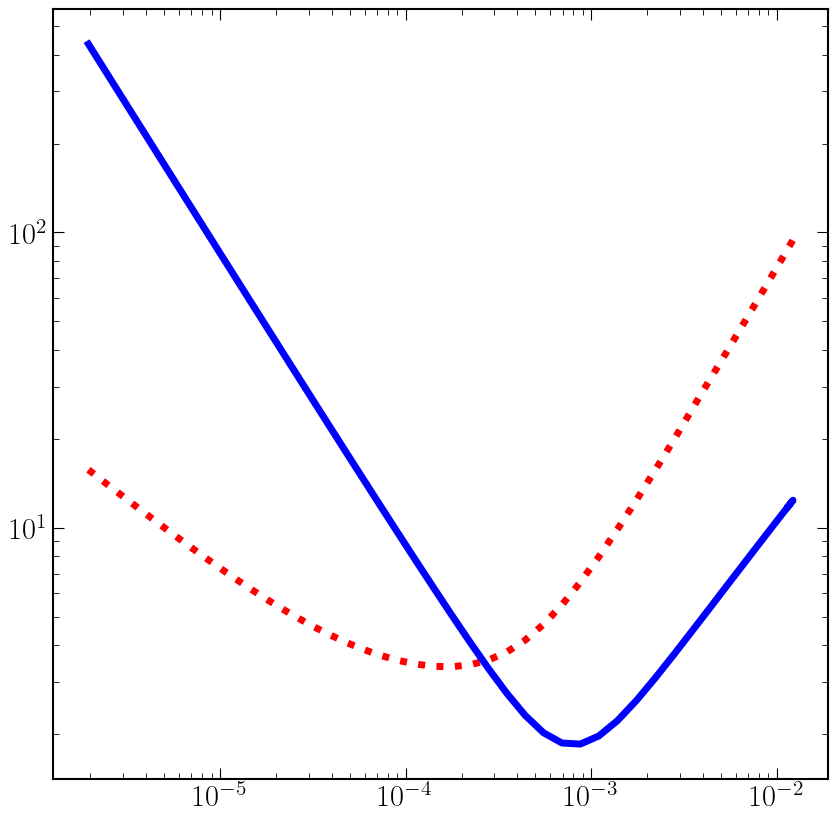

In [733]:

plt.figure(figsize=(10, 10))
plt.loglog(Ic_data_example, measured_noise_ic*1e9, lw=5, color='red', linestyle = 'dotted', label=r'$\boldsymbol{\sqrt{S_{v,meas}}}$ @ Ic = %.3f mA' % (Ic*1e3))
plt.loglog(Ic_data_example, fitted_noise_ic * 1e9, lw=5, color='blue', label=r'$\boldsymbol{\sqrt{S_{v,fit}}}$ @ Ic = %.3f mA' % (Ic*1e3))

<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\g'
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/4239982914.py:20: SyntaxWarning: invalid escape sequence '\g'
  f'(KF={KF_opt:.2e}, $\gamma$={afn_opt:.2f})'
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/4239982914.py:36: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Input-Referred Noise ($\mathrm{V}/\sqrt{\mathrm{Hz}}$)', fontsize=12)
/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_6735/4239982914.py:80: SyntaxWarning: invalid escape sequence '\g'
  print(f"Optimal afn (Current Exponent, $\gamma$): {afn_fit:.3f}")



--- Starting Noise vs. Current Fit with Plotting ---
✅ Fit Successful (Noise vs. Ic Sweep)!
Optimal KF (Flicker Noise Factor): 7.739e-11
Optimal afn (Current Exponent, $\gamma$): 1.406


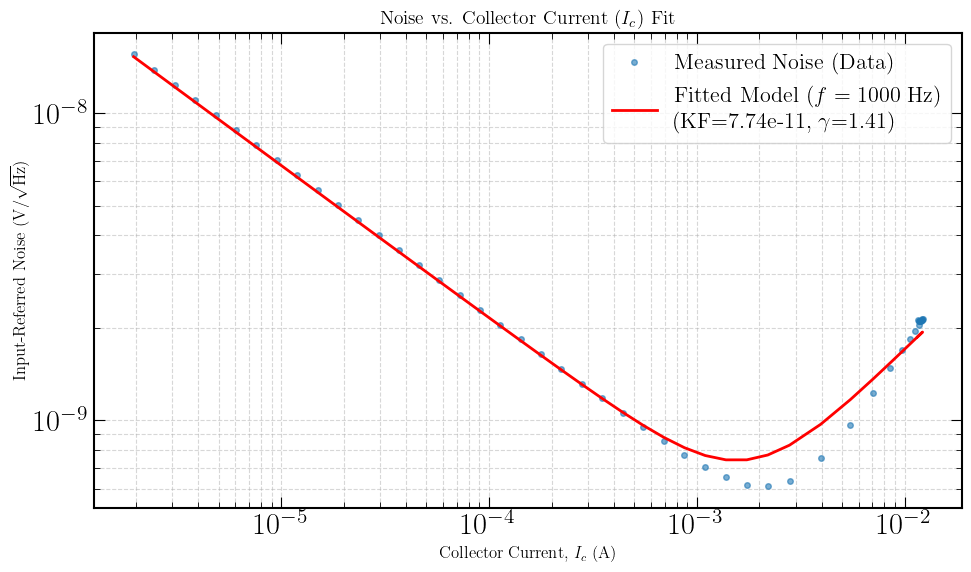

In [736]:



def plot_noise_vs_ic_fit(Ic_data, measured_noise, fitted_noise, f_fixed, KF_opt, afn_opt):
    """
    Plots the measured and fitted Input-Referred Noise (ASD) vs. Ic on a log-log scale.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 1. Plot Measured Data
    ax.loglog(
        Ic_data, 
        measured_noise, 
        'o', 
        markersize=4, 
        alpha=0.6, 
        label='Measured Noise (Data)'
    )
    
    # 2. Plot Fitted Model
    fit_label = (
        f'Fitted Model ($f={f_fixed}$ Hz)\n'
        f'(KF={KF_opt:.2e}, $\gamma$={afn_opt:.2f})'
    )
    ax.loglog(
        Ic_data, 
        fitted_noise, 
        'r-', 
        linewidth=2, 
        label=fit_label
    )
    
    # 3. Enhance Plot Appearance
    ax.set_title(
        'Noise vs. Collector Current ($I_c$) Fit',
        fontsize=14
    )
    ax.set_xlabel('Collector Current, $I_c$ (A)', fontsize=12)
    ax.set_ylabel('Input-Referred Noise ($\mathrm{V}/\sqrt{\mathrm{Hz}}$)', fontsize=12)
    ax.grid(which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


def fit_noise_vs_ic_log(
    Ic_data, measured_noise_data, f_fixed, Ic2, El, Nx, Nx2, beta, 
    p0_guess=None, plot_result=True # <-- NEW Plot Option
):
    """
    Fits the input_referred_noise model to measured data using a log-log approach,
    where the X-axis is the collector current (Ic).
    """
    global k, q, T, constRI 
    
    if p0_guess is None:
        p0_guess = [1e-10, 1.0] 

    def log_model_ic_sweep(Ic_array, KF, afn):
        # Passes Ic_array as the sweeping variable and f_fixed as the scalar frequency
        noise_asd = input_referred_noise(
            Ic=Ic_array, Ic2=Ic2, El=El, Nx=Nx, Nx2=Nx2, beta=beta, 
            f=f_fixed, KF=KF, gamma=afn, constRI=constRI, T=T
        )
        return np.log(noise_asd)

    log_data = np.log(measured_noise_data)
    
    try:
        popt, pcov = curve_fit(
            f=log_model_ic_sweep, 
            xdata=Ic_data,
            ydata=log_data, 
            p0=p0_guess,
            bounds=([1e-20, 0.0], [1.0, 3.0]) 
        )
        
        KF_fit, afn_fit = popt
        
        print(f"✅ Fit Successful (Noise vs. Ic Sweep)!")
        print(f"Optimal KF (Flicker Noise Factor): {KF_fit:.3e}")
        print(f"Optimal afn (Current Exponent, $\gamma$): {afn_fit:.3f}")
        
        # --- PLOTTING EXECUTION ---
        if plot_result:
            # Calculate the model using the fitted parameters for plotting
            fitted_noise = input_referred_noise(
                Ic_data, Ic2, El, Nx, Nx2, beta, f_fixed, KF_fit, afn_fit, constRI, T
            )
            plot_noise_vs_ic_fit(
                Ic_data, measured_noise_data, fitted_noise, f_fixed, KF_fit, afn_fit
            )

        return popt, pcov

    except RuntimeError as e:
        print(f"❌ Fit Failed: {e}")
        return None, None


# --- Example Usage ---

# 1. Define fixed parameters and dummy data (for demonstration)

El_val = 5.0
Nx_val = 50.0
Nx2_val = 90.0
beta_val = 600.0
f_meas = 1000  # Noise is measured at 100 Hz

# Create dummy Ic data (spanning decades, e.g., 1 uA to 10 mA)
Ic_data_example = Ic_val = compare_opt['Ic'].values
Ic2_val = 1.5*Ic_data_example
# True values for dummy data creation
KF_true_val = 3.5e-11
afn_true_val = 1.05

true_noise_ic = input_referred_noise(
    Ic_data_example, Ic2_val, El_val, Nx_val, Nx2_val, beta_val, 
    f_meas, KF_true_val, afn_true_val, constRI, T
)
# Add noise to simulate measured data
measured_noise_ic = compare_opt['Noise_1kHz'].values  # Replace with actual measured data

# 2. Call the fitting function with plotting enabled (default)
print("\n--- Starting Noise vs. Current Fit with Plotting ---")
optimal_params_ic, covariance_ic = fit_noise_vs_ic_log(
    Ic_data_example, 
    measured_noise_ic, 
    f_fixed=f_meas,
    Ic2=Ic2_val, El=El_val, Nx=Nx_val, Nx2=Nx2_val, beta=beta_val,
    p0_guess=[1e-12, 0.9],
    plot_result=True # This is the new option
)